# Lane Changing Strategies in 2D Traffic Cellular Automata
# Kees Til, Azer Aras, Mike de Haan


## Introduction
The Nagel-Schreckenberg model is a cellular automaton model designed to simulate traffic flows. For this project, we studied an extension of the classical Nagel-Schreckenberg model with multiple parallel lanes. We investigated the efficiency of the traffic flow under different lane changing rules. We then considered an additional extension of the model, by considering traffic which consists of vehicles with different maximal velocities, and again examined efficiency under different lane changing rules.

## One-dimensional Nagel-Schreckenberg model

The one-dimensional Nagel-Schreckenberg model is a traffic simulation model that is discrete in both time and space. The system consists of a one-dimensional grid of L sites with periodic boundary conditions. A site can either 
be empty, or occupied by a vehicle of velocity $0$ to $v_{\max}$. The velocity
is equivalent to the number of sites that a vehicle
advances in one update — provided that there are no obstacles ahead. Vehicles
move only in one direction. The index $i$ is used to identify a specific vehicle, $x(i)$ denotes its
position, $v(i)$ its current velocity, $v_{\max}(i)$ its maximum velocity and $\text{gap}_f(i) := x(\text{suc}(i)) − x(i) − 1$ the width of the gap to the successor, where the $f$ stands for 'front'. Similarly $\text{gap}_b(i)$ denotes the width of the gap between $i$ and its predecessor. At the beginning of each time step, the the following rules are applied to
all vehicles simultaneously. Then the vehicles are advanced according to their new velocities. 

$
\begin{align}
v(i) \neq v_{\max}(i) \Longrightarrow v(i) = v(i) + 1
\end{align}
$

$
\begin{align}
v(i) > \text{gap}(i) \Longrightarrow v(i) = \text{gap}(i)
\end{align}
$

$
\begin{align}
v(i) > 0 \text{ and } \text{rand} < p_s \Longrightarrow v(i) = v(i) - 1
\end{align}
$

Here, the parameter $p_s$ is the slowdown probability; the probability that a vehicle's velocity is randomly decreased. The number rand is drawn randomly from a uniform $(0,1)$ distribution.
This one-dimensional model is able to recreate the type of traffic jams that are observed in real-world traffic.
![image](Nagel1D.png)

## Two-dimensional Nagel-Schreckenberg model

In the two dimensional Nagel-Schreckenberg model, we are no longer dealing with a single lane, but with multiple parallel lanes. Now, two steps are executed:

- Lane changing. Perform exchange of vehicles between the lanes according to a chosen lane changing rule. Vehicles are only moved sideways. They do not advance.
This first sub-step is implemented as strict parallel update with each vehicle
making its decision based upon the configuration at the beginning of
the time step.


- Perform independent single lane updates on both lanes according to the
single lane update rules. In this second sub-step the resulting configuration
of the first sub-step is used.

Thus, the horizontal advancement of vehicles in each timestep is now preceded by a possible verticle movement: lane changing.
For each vehicle, it has to be decided at each timestep whether changing lanes is desirable and possible. To determine this, many different strategies can be used. Below, we introduce three lane changing strategies that we investigated. 

In the strategies below, the parameter $p_c$ is the lane changing probability. This is the probability with which a vehicle that is able to change lanes desirably will actually change lanes. The subscripts $f,b,c,l$ and $r$ stand for 'front', 'back', 'current', 'left' and 'right', respectively. So, for instance, $\text{gap}_{b,l}(i)$ is the gap between vehicle $i$ and its predecessor if it were to move to the left lane, and $v_l(\text{pred}(i))$ is the velocity of the vehicle that will be immediately behind $i$ if $i$ moves to the left lane. See also the image below.

### Random lane changing rule 
With probability $p_c$:
- switch left if
    - position left is empty
    
    
- switch right if
    - position right is empty 


### American lane changing rule
With probability $p_c$:
- switch left if

    - position left is empty
    - $\text{gap}_{f,c}(i) \leq \text{gap}_{f,l}(i)$
    - $\text{gap}_{f,c}(\text{suc}(i)) \leq \text{gap}_{f,l}(\text{suc}(i))$
    - $\text{gap}_{b,l}(i) - v_l(\text{pred}(i)) \geq -1$
    
    
- switch right if

    - position right is empty
    - $\text{gap}_{f,c}(i) \leq \text{gap}_{f,r}(i)$
    - $\text{gap}_{f,c}(\text{suc}(i)) \leq \text{gap}_{f,r}(\text{suc}(i))$
    - $\text{gap}_{b,r}(i) - v_r(\text{pred}(i)) \geq -1$
    
![image](Nagel2D.png)

### European lane changing rule
The European lane changing rule is identical to the American lane changing rule, with the following addition:

- preference for right lane

    - if $i$ can switch to both left and right: $p_{right} = 0.85, p_{left} = 0.15$

Moreover, the single lane update is now slightly different, since cars can't overtake on the right side under this rule, unless there is a traffic jam.

$
\begin{align}
v(i) \neq v_{\max}(i) \Longrightarrow v(i) = v(i) + 1
\end{align}
$

$
\begin{align}
v(i) > \min\{\text{gap}_{f,c}(i), \text{gap}_{f,l}(i)\}  \Longrightarrow v(i) = \min\{\text{gap}_{c,f}(i), \text{gap}_{f,l}(i)\}
\end{align}
$

$
\begin{align}
v(i) > 0 \text{ and } \text{rand} < p_s \Longrightarrow v(i) = v(i) - 1
\end{align}
$

The second condition ensures that overtaking on the right is no longer possible.

## American vs European

#### Flux
<table>
         <tr>
         <th><img src="Figures/symmFlux2Lane.png"/></th>
         <th><img src="Figures/randFlux2Lane.png"/></th>
         </tr>
</table>

#### Speed
<table>
         <tr>
         <th><img src="Figures/symmSpeed2Lane.png"/></th>
         <th><img src="Figures/randSpeed2Lane.png"/></th>
         </tr>
</table>

#### Jam
<table>
         <tr>
         <th><img src="Figures/symmJam2Lane.png"/></th>
         <th><img src="Figures/randJam2Lane.png"/></th>
         </tr>
</table>

#### Standard deviation
<table>
         <tr>
         <th><img src="Figures/symmStdLanes2.png"/></th>
         <th><img src="Figures/euroStdLanes.png"/></th>
         <!--<th><img src="Figures/euroStdLanes.png"/></th>-->
         </tr>
</table>
<img src="Figures/symmStdLanes3uni.png"/></th>


# Lane changing with fast and slow vehicles
Not every vehicle on a highway is able or allowed to move at the same velocity. For example, in the Netherlands, trucks and most buses face a legal speed limit of 80 km/hour, while passenger cars are allowed to drive at 130 km/hour.
We therefore extended the previously described model to allow vehicles with differing maximum velocities. Specifically, we studied a situation with two types of vehicles: 'fast' and 'slow'.

In this model, we compared a symmetric and an assymetric lane changing rule, as described in the paper $\textit{Particle hopping models for two-lane traffic with two kinds of vehicles: Effects of lane-changing rules}$ (1997) by Chowdhury, Wolf and Schreckenberg. In the assymetric lane changing rule, the conditions for switching to the left lane are different from the conditions for switching to the right lane, and the lane changing conditions for fast vehicles are different from the lane changing conditions for slow vehicles. Using the same notation as before, these lane changing strategies are defined as follows:

### Symmetric lane changing rule
With probability $p_c$:
- switch left if
    - $\text{gap}_{f,c}(i) < v(i) + 1$ 
    - $\text{gap}_{f,c}(i) < \text{gap}_{f,l}(i)$
    - position left is empty
    - $v_{\text{max},l}(\text{pred}(i)) < \text{gap}_{b,l}(i)$
- switch right if
    - $\text{gap}_{f,c}(i) < v(i) + 1$ 
    - $\text{gap}_{f,c}(i) < \text{gap}_{f,r}(i)$
    - position right is empty
    - $v_{\text{max},r}(\text{pred}(i)) < \text{gap}_{b,r}(i)$    

### Asymmetric lane changing rule
With probability $p_c$:
- switch left if:
    - $\text{gap}_{f,c} < v(i) + 1$ or $i$ is fast and sees a slow vehicle within distance $v_{\max}(i)$
    - $\text{gap}_{f,c}(i) < \text{gap}_{f,l}(i)$
    - position left is empty
    - $v_{\text{max},l}(\text{pred}(i)) < \text{gap}_{b,l}(i)$

- switch right if:
    - $i$ is slow, or $i$ is fast and has no slow vehicle within distance $v_{\max}(i)$ if it would switch to the right
    - gap_{f,r}(i) > v(i)
    - position right is empty
    - $v_{\text{max},r}(\text{pred}(i)) < \text{gap}_{b,r}(i)$
    


In [30]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as patches
import itertools
from IPython.display import HTML
from matplotlib import rc

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


# rc('animation', html='none')
%matplotlib notebook
# %matplotlib nbagg
# % matplotlib inline

In [31]:
class Car2(object):
	def __init__(self, vMax, vIn, pos, ID, speed):
		'''
		A simple car object which holds the properties for each individual 'state'
		
		@param vMax: Maximum speed for this car
		@param vIn: Initial speed of the car
		@param pos: Initial position of the car (tuple of coordinates of grid)
		@param ID: The id of the vehicle
		'''
		self.vMax = vMax
		self.v = vIn  # Current speed of the car
		self.posCurrent = pos # Most recent position at timestep i
		self.posPrevious = pos  # Position at timestep i-1 for animation purposes
		self.ID = ID  # Id of the car on the grid
		self.speed = speed # Determines if vehicle is of type 'fast' or 'slow'

class CAtwoD2(object):
	def __init__(self, N, M, start, pSlow, maxvel, pChange, strategy):
		'''
		The object containing the grid and the logic of the model
		
		@param N: The amount of grids in the x direction
		@param M: The amount of grids in the y direction(no. of lanes)
		@param start: A list of car objects to put on the grid
		@param pSlot: The Nagel-Schreckenberg slowdown probability
		@param maxvel: Maximum velocity (deprecated as each car has one..)
		@param pChange: Lane changing probability in the retard model.
		'''
		self.N, self.M = N, M
		self.grid = np.zeros((N,M), dtype=int) # Used mostly as reference
		self.pSlow, self.pChange = pSlow, pChange
		self.strategy = strategy
		self.maxvel = maxvel
		self.cars = len(start)  # number of cars on the road..
		
		self.carIndex = {}
		
		for car in start:
			self.carIndex[car.ID] = deepcopy(car)  # Copy the car object according to id
			self.grid[car.posCurrent] = car.ID  # Add the car IDs on the grid
			
		self.fluxCounter = 0
		self.slowFluxCounter = 0
		self.fastFluxCounter = 0			

	def changeCriteria2(self, ID, lane):
		'''
		Function which finds the gap between the vehicle in front, behind, relative
		velocities between the vehicles. This data should allow for the information
		a car needs to decide between changing lanes
		
		@param ID: ID of the car we want to find the data for
		@param lane: For which lane we want to estimate this (can be current or
		neighbouring lanes)
		'''
		
		currentCar = self.carIndex[ID]
		i, j = currentCar.posCurrent[0], lane
		
		
		# Find the gap in front, and velocity of car in front if applicable
		frontGap = 10**6  # initialize at arbitrary very high number
		frontVel = 0
		frontVelMax = 0
		slowerCarAhead = False
		found = False
		for k in range(1, currentCar.vMax):
			if self.grid[(i+k) % self.N, j] != 0:  # Car is found
				if found == False:
					frontGap = k-1 
					frontVel = self.carIndex[self.grid[(i+k) % self.N, j]].v
					frontVelMax = self.carIndex[self.grid[(i+k) % self.N, j]].vMax
					found = True
				if self.carIndex[self.grid[(i+k) % self.N, j]].vMax < currentCar.vMax:
					slowerCarAhead = True
					break
			
		# Find the gap at back and the velocity if applicable
		backGap = 10**6  # initialize at arbitrary very high number
		backVel = 0
		backVelMax = 0
		for k in range(1, currentCar.vMax):

			if self.grid[(i-k) % self.N, j] != 0:  # Car is found
				backGap = k-1 
				backVel = self.carIndex[self.grid[(i-k) % self.N, j]].v
				backVelMax = self.carIndex[self.grid[(i-k) % self.N, j]].vMax
				break
			
		return frontGap, frontVel, frontVelMax, backGap, backVel, backVelMax, slowerCarAhead

			
	def laneChangeRandom2(self):
		'''
		The lane changing logic which is performed before the movement is executed
		'''
		for car in self.carIndex.values():
			i, j = car.posCurrent[0], car.posCurrent[1]
			# A vehicle changes lanes at random if the lane next to it
			# has room (a vacant space) next to it

			possShifts = []
			if j - 1 >= 0:
				if self.grid[i,j-1] == False:
					possShifts.append(-1)
			if j + 1 < self.M:
				if self.grid[i,j+1] == False:
					possShifts.append(1)
					
			if len(possShifts) > 0 and np.random.rand() < self.pChange:
				shift = np.random.choice(possShifts)
			
				car.posCurrent = (i, j+shift) # Change lane in car
				
				# Update the data in the grid
				self.grid[i,j] = 0
				self.grid[i, j+shift] = car.ID
	
	def laneChangeSymmetric2(self):
		# Symmetric lane changing
		for car in self.carIndex.values():
			i, j = car.posCurrent[0], car.posCurrent[1]
			possShifts = [] # Store the shifts that might be done
			frontGap, frontVel, frontVelMax, backGap, backVel, backVelMax, slowerCarAhead = self.changeCriteria2(car.ID, j)	

			# All logic for the left lane resides here
			if j - 1 >= 0: # The left lane actually exists
				leftFrontGap, leftFrontVel, leftFrontVelMax, leftBackGap, leftBackVel, leftBackVelMax, leftSlowerCarAhead = self.changeCriteria2(car.ID, j-1)
				
				# Condition a
				if frontGap < car.v + 1:
					a = True
				else:
					a = False
				
				# Condition b
				if leftFrontGap > frontGap:
					b = True
				else:
					b = False
				
				# Condition c
				if self.grid[i, j-1] == 0:
					c = True
				else:
					c = False		
					
				# Condition d
				if leftBackVelMax < leftBackGap:
					d = True 
				else:
					d = False
					
				if a and b and c and d:
					possShifts.append(-1)
					
			# Right side logic
			if j + 1 < self.M : # The right lane actually exists
				rightFrontGap, rightFrontVel, rightFrontVelMax, rightBackGap, rightBackVel, rightBackVelMax, rightSlowerCarAhead = self.changeCriteria2(car.ID, j+1)
				
				# Condition a
				if frontGap < car.v + 1:
					a = True
				else:
					a = False
				
				# Condition b
				if rightFrontGap > frontGap:
					b = True
				else:
					b = False
				
				# Condition c
				if self.grid[i, j+1] == 0:
					c = True
				else:
					c = False		
					
				# Condition d
				if rightBackVelMax < rightBackGap:
					d = True 
				else:
					d = False
					
				if a and b and c and d:
					possShifts.append(1)
					
					
			# Logic regarding actually doing the lane change resides here
			if len(possShifts) > 0 and np.random.rand() < self.pChange:
				shift = np.random.choice(possShifts)
				car.posCurrent = (i, j+shift) # Change lane in car
				
				# Update the data in the grid
				self.grid[i,j] = 0
				self.grid[i, j+shift] = car.ID								

	def laneChangeAsymmetric2(self):
		# Asymmetric lane changing
		for car in self.carIndex.values():
			i, j = car.posCurrent[0], car.posCurrent[1]
			possShifts = [] # Store the shifts that might be done
			frontGap, frontVel, frontVelMax, backGap, backVel, backVelMax, slowerCarAhead = self.changeCriteria2(car.ID, j)	

			# Change to left lane
			if j + 1 < self.M : # The left lane actually exists
				leftFrontGap, leftFrontVel, leftFrontVelMax, leftBackGap, leftBackVel, leftBackVelMax, leftSlowerCarAhead = self.changeCriteria2(car.ID, j+1)
				
				# Condition a 
				if (frontGap < car.v + 1) or slowerCarAhead:
					a = True
				else:
					a = False

				if leftFrontGap > frontGap:
					b = True
				else:
					b = False

				if self.grid[i, j+1] == 0:
					c = True
				else:
					c = False		
					
				if leftBackVelMax < leftBackGap:
					d = True 
				else:
					d = False
					
				if a and b and c and d:
					possShifts.append(1)
					
			# Change to right lane
			if j - 1 >= 0 : # The right lane actually exists
				rightFrontGap, rightFrontVel, rightFrontVelMax, rightBackGap, rightBackVel, rightBackVelMax, rightSlowerCarAhead = self.changeCriteria2(car.ID, j-1)

				if car.speed == 'fast' and rightSlowerCarAhead:
					a = False
				else:
					a = True

				if rightFrontGap > car.v:
					b = True
				else:
					b = False

				if self.grid[i, j-1] == 0:
					c = True
				else:
					c = False		

				if rightBackVelMax < rightBackGap:
					d = True 
				else:
					d = False		
			
				if a and b and c and d:
					possShifts.append(-1)
					
					
			# Logic regarding actually doing the lane change resides here
			if len(possShifts) > 0 and np.random.rand() < self.pChange:
				shift = np.random.choice(possShifts)
				car.posCurrent = (i, j+shift) # Change lane in car
				
				# Update the data in the grid
				self.grid[i,j] = 0
				self.grid[i, j+shift] = car.ID						
				
	def moveTimeStep2(self):
		''' 
		Simulate the movement of each of the vehicles according to Nagel-Schrecken
		'''

		# First increase speed with 1 if maxspeed has not been reached
		# All these functions use the positions of the car objects and reference
		# the grid for finding id and updating the position in the grid
		for car in self.carIndex.values():  
			if car.v < car.vMax:
				car.v += 1
				
		# Check if any cars in front are within maxspeed distance and slow down
		for car in self.carIndex.values():
			
			for j in range(1, car.v + 1):
				if self.grid[(car.posCurrent[0] + j) % self.N, car.posCurrent[1]]:
					car.v = j-1  # Reduce speed so a crash is prevented
					break # No need to check other squares further in front
					
		# Randomize speeds/slowdowns
		for car in self.carIndex.values():
			if np.random.rand() < self.pSlow and car.v > 0:
				car.v  -= 1
			
		# Move the cars forward depending on their speed
		for car in self.carIndex.values():
			# Generate the new position of this car
			posCurrent = car.posCurrent
			newPos = ((posCurrent[0] + car.v) % self.N, posCurrent[1])
			
			# Update the grid
			self.grid[posCurrent] = 0
			self.grid[newPos] = car.ID
			
			# The moment when a car passes the periodic boundary
			if (posCurrent[0] + car.v) >= N:
				self.fluxCounter += 1
				if car.speed == 'slow':
					self.slowFluxCounter += 1
				else:
					self.fastFluxCounter += 1
			
			# Update the position of the car object
			car.posCurrent = newPos
		
		
	def updateGrid2(self):
		'''
		The updating step doing all the actions for a timestep
		'''
		
		# First update the previous position for each of the cars to the current pos
		for i in self.carIndex.keys():
			self.carIndex[i].posPrevious = self.carIndex[i].posCurrent
				
		if self.strategy == 'random':
			self.laneChangeRandom2()
		elif self.strategy == 'symmetric':
			self.laneChangeSymmetric2()
		elif self.strategy == 'asymmetric':
			self.laneChangeAsymmetric2()	
		self.moveTimeStep()
	
	def returnAverageVelocity2(self):
		avSpeed = 0
		
		for car in self.carIndex.values():
			avSpeed += car.v
		return avSpeed/len(self.carIndex.keys())
	
	def returnPlotState2(self):
		plotState, distances = [], []
		for car in self.carIndex.values():
			plotState.append((car.posPrevious, car.posCurrent))
			distances.append(car.v)
		return plotState, distances
	
def generateStart2(N, M, num, maxV1, maxV2, proportion):
	'''
	Generates a list of tuples containing grid coordinates on which vehicles are
	initialized
	
	@param N: Amount of discretizations in the x-direction
	@param M: Amount of discretizations in the y-direction (lanes)
	@param num: Amount of vehicles to generate. Must be <= N*M
	'''
	
	start = set()  # Set to prevent duplicates
	
	while len(start) < num:
		start.add((np.random.randint(0, N), np.random.randint(0,M)))
		
	cars = []
	start = list(start)
	for i in range(int(proportion*len(start))):
		cars.append(Car2(maxV1,1,start[i], i+1, 'slow'))
	for i in range(int(proportion*len(start)),len(start)):
		cars.append(Car2(maxV2,1,start[i], i+1, 'fast'))	
	return cars

In [34]:
def animationShow2(N,M,carnum, pChange, pSlow, strategy, maxVel1, maxVel2, proportion):
    
    def findCoors(N, M, xmin, xmax, ymin, ymax ):
        '''
        Subdivide the x and y into N and M parts for the backgrounds
        ''' 
        dx, dy = float(xmax - xmin)/N, float(ymax - ymin)/M 
        coors = []
        trans = {}
        for i in zip(np.linspace(xmin, xmax, N), range(N)):
            for j in zip(np.linspace(ymax, ymin, M), range(M)):
                coors.append((i[0], j[0]))
                trans[(i[1], j[1])] = (i[0] + dx/2, j[0] + dy/2)

        return coors, float(xmax - xmin)/N, float(ymax - ymin)/M , trans


    def init():
        line.set_data([], [])
        time_text.set_text('')
        return line, time_text

    def animateDataGen(lim):
        n = 0
        maxDist = xmax + dx
        while n < lim:
            test.updateGrid2()
            points, vels = test.returnPlotState2()
            realSpacePoints = []
            realSpaceDistances = []

            # Translate the grid coordinates to real space
            for i in range(len(vels)):
                realSpacePoints.append([trans[points[i][0]], trans[points[i][1]]])
                realSpaceDistances.append(dx*vels[i])

            # Create two arrays, containing intermediate x and y coordinates
            xPoints, yPoints = [], []

            for i in range(len(vels)):
                xCoors = np.linspace(realSpacePoints[i][0][0], 
                                            realSpacePoints[i][0][0] + realSpaceDistances[i], 
                                            steps) % maxDist
                yCoors = np.linspace(realSpacePoints[i][0][1], realSpacePoints[i][1][1], steps)

                xPoints.append(xCoors)
                yPoints.append(yCoors)

            # Run through each of the coordinates and yield a list of x and y plot vals
            for i in range(steps - 1):
                xList, yList = [], []
                for j in range(len(vels)):
                    xList.append(xPoints[j][i])
                    yList.append(yPoints[j][i])
                yield xList, yList

            n += 1


    def animate2(i):
        try:
            thisx, thisy = next(dataGen)
        except:
            thisx, thisy = [], []
        ycoordinates.extend(thisy)

        line.set_data(thisx, thisy)
        time_text.set_text(time_template.format(int(i/steps), i%steps,test.fluxCounter))


        return line, time_text

    animatie = True

    # Starting cars
    start = generateStart2(N, M, carnum, maxVel1, maxVel2,proportion)

    # Create a CA object
    test = CAtwoD2(N, M, start, pSlow, maxVel1, pChange, strategy)

    xmin, xmax, ymin, ymax = 0, 10, -0.5, 0.5  # For plotting
    ycoordinates = []
    # Find the translations for plotting the grid
    coors,dx,dy,trans = findCoors(N, M, xmin, xmax, ymin, ymax)


    # These are variables for the plotting stuff
    steps = 30
    lim = 500

    if animatie:
        dataGen = animateDataGen(lim)
        fig = plt.figure()
        ax = fig.add_subplot(111, autoscale_on=False, xlim=(xmin, xmax), ylim=(ymin, ymax))

        # Paint a background grid..
        for i in coors:
            ax.add_patch(
                    patches.Rectangle(
                i,   # (x,y)
                dx,          # width
                dy,          # height
                color='black', 
                    fill=False
            )
        )

        line, = ax.plot([], [], 'rs', markersize=xmax/(0.05*N))
        time_template = 'timestep {0}, frame {1}, Counter {2}'
        time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)
        plt.axis('equal')


        ani = animation.FuncAnimation(fig, animate2, lim*(steps-1),
                                               interval=3, blit=True, init_func=init, repeat=False)
        return ani

    # 	HTML(ani.to_html5_video())

<IPython.core.display.Javascript object>


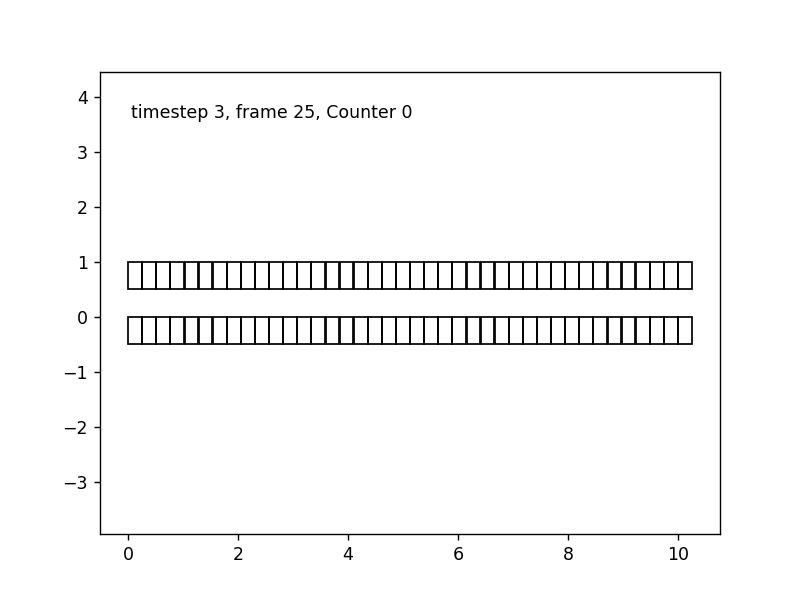

In [35]:
interact_manual(animationShow2, 
        N=widgets.IntSlider(min=20,max=80,step=1,value=40),
        M=widgets.IntSlider(min=1,max=4,step=1,value=2),
        carnum=widgets.IntSlider(min=1,max=320,step=1,value=30),
        pChange = widgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.1),
        pSlow= widgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.1),
        maxVel1=widgets.IntSlider(min=1,max=10,step=1,value=5),
        maxVel2=widgets.IntSlider(min=1,max=10,step=1,value=5),
        proportion = widgets.FloatSlider(min=0.1,max=0.9,step = 0.05, value = 0.5),
        strategy=['random', 'symmetric', 'asymmetric']
        );

## Results: symmetric vs asymmetric lane changing
#### Flux: Total, fast vehicles and slow vehicles
The figures below show the total flux, the flux of fast vehicles and the flux of slow vehicles, respectively, at different densities with 25% slow vehicles and 75% fast vehicles.
<table>
         <tr>
         <th><img src="Total.png"/></th>
         <th><img src="Fast.png"/></th>
         <th><img src="Slow.png"/></th>
         </tr>
</table>

# Conclusion

Need to be written...

In the case of fast and slow vehicles, we find that the flux of slow vehicles is the same under symmetric and the asymmetric lane changing for all densities. However, the flux of vast vehicles at low densities is higher under asymmetric lane changing then under symmetric lane changing, and, as a result, the same is true of the total flux. We therefore find asymmetric lane changing to be more efficient than symmetric lane changing, at low traffic densities.

In [24]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as patches
import itertools
from IPython.display import HTML
from matplotlib import rc

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


# rc('animation', html='none')
%matplotlib notebook
# %matplotlib nbagg
# % matplotlib inline

In [25]:

################################## Stuff for the model  #######################
class Car(object):
	def __init__(self, vMax, vIn, pos, ID, pLaneChange):
		'''
		A simple car object which holds the properties for each individual 'state'
		
		@param vMax: Maximum speed for this car
		@param vIn: Initial speed of the car
		@param pos: Initial position of the car (tuple of coordinates of grid)
		@param ID: The id of the vehicle
		'''
		self.vMax = vMax
		self.v = vIn  # Current speed of the car
		self.posCurrent = pos # Most recent position at timestep i
		self.posPrevious = pos  # Position at timestep i-1 for animation purposes
		self.ID = ID  # Id of the car on the grid
		self.pLaneChange = pLaneChange  # Probability of this car performing lane changes
		
		

class CAtwoD(object):
	def __init__(self, N, M, start, pSlow, maxvel, pChange, strategy):
		'''
		The object containing the grid and the logic of the model
		
		@param N: The amount of grids in the x direction
		@param M: The amount of grids in the y direction(no. of lanes)
		@param start: A list of car objects to put on the grid
		@param pSlot: The Nagel-Schreckenberg slowdown probability
		@param maxvel: Maximum velocity (deprecated as each car has one..)
		@param pChange: Lane changing probability in the retard model.
		'''
		self.N, self.M = N, M
		self.grid = np.zeros((N,M), dtype=int) # Used mostly as reference
		self.pSlow, self.pChange = pSlow, pChange
		self.strategy = strategy
		self.maxvel = maxvel
		self.cars = len(start)  # Amount of cars on the road..
		
		self.carIndex = {}
		
		for car in start:
			self.carIndex[car.ID] = deepcopy(car)  # Copy the car object according to id
			self.grid[car.posCurrent] = car.ID  # Add the car id's on the grid
			
		self.fluxCounter = 0  # Can be used to measure congestion.	
		self.movementCounter = 0

	def changeCriteria(self, ID, lane):
		'''
		Function which finds the gap between the vehicle in front, behind, relative
		velocities between the vehicles. This data should allow for the information
		a car needs to decide between changing lanes
		
		@param ID: ID of the car we want to find the data for
		@param lane: For which lane we want to estimate this (can be current or
		neighbouring lanes)
		'''
		
		currentCar = self.carIndex[ID]
		i, j = currentCar.posCurrent[0], lane
		
		
		# Find the gap in front, and velocity of car in front if applicable
		frontGap = self.maxvel  # init at max value road
		frontVel = 0
		for k in range(1, self.maxvel + 1):

			if self.grid[(i+k) % self.N, j] != 0:  # Car is found
				frontGap = k-1 
				frontVel = self.carIndex[self.grid[(i+k) % self.N, j]].v
				break
			
		# Find the gap at back and the velocity if applicable
		
				# Find the gap in front
		backGap = self.maxvel  # init at max value road
		backVel = 0
		for k in range(1, self.maxvel + 1):

			if self.grid[(i-k) % self.N, j] != 0:  # Car is found
				backGap = k-1 
				backVel = self.carIndex[self.grid[(i-k) % self.N, j]].v
				break
			
		return frontGap, frontVel, backGap, backVel
	
	def changeCriteriaEuro(self, ID, lane):
		'''
		Function which finds the gap between the vehicle in front, behind, relative
		velocities between the vehicles. This data should allow for the information
		a car needs to decide between changing lanes
		
		@param ID: ID of the car we want to find the data for
		@param lane: For which lane we want to estimate this (can be current or
		neighbouring lanes)
		'''
		
		currentCar = self.carIndex[ID]
		i, j = currentCar.posCurrent[0], lane
		
		
		# Find the gap in front, and velocity of car in front if applicable
		frontGap = self.maxvel  # init at max value road
		frontVel = 0
		frontCar = currentCar
		for k in range(1, self.maxvel + 1):

			if self.grid[(i+k) % self.N, j] != 0:  # Car is found
				frontGap = k-1 
				frontVel = self.carIndex[self.grid[(i+k) % self.N, j]].v
				frontCar = self.carIndex[self.grid[(i+k) % self.N, j]]
				break
			
		# Find the gap at back and the velocity if applicable
		
				# Find the gap in front
		backGap = self.maxvel  # init at max value road
		backVel = 0
		backCar = currentCar
		for k in range(1, self.maxvel + 1):

			if self.grid[(i-k) % self.N, j] != 0:  # Car is found
				backGap = k-1 
				backVel = self.carIndex[self.grid[(i-k) % self.N, j]].v
				backCar = self.carIndex[self.grid[(i-k) % self.N, j]]  
				break
			
		return frontGap, frontVel, backGap, backVel, frontCar, backCar
	
	def changeCriteriaPlus(self, ID, lane):
		'''
		Function which finds the gap between the vehicle in front, behind, relative
		velocities between the vehicles. This data should allow for the information
		a car needs to decide between changing lanes. Also finds the second gap,
		so the gap front gap of the car in front.
		
		@param ID: ID of the car we want to find the data for
		@param lane: For which lane we want to estimate this (can be current or
		neighbouring lanes)
		'''
		
		currentCar = self.carIndex[ID]
		i, j = currentCar.posCurrent[0], lane
		
		
		# Find the gap in front, and velocity of car in front if applicable
		frontGap = self.maxvel  # init at max value road
		frontVel = 0
		frontCar = currentCar
		for k in range(1, self.maxvel + 1):

			if self.grid[(i+k) % self.N, j] != 0:  # Car is found
				frontGap = k-1 
				frontVel = self.carIndex[self.grid[(i+k) % self.N, j]].v
				frontCar = self.carIndex[self.grid[(i+k) % self.N, j]]
				break
			
		frontFrontGap = self.maxvel
		m = frontCar.posCurrent[0]
		
		for k in range(1, self.maxvel + 1):
			if self.grid[(m +k) % self.N, j] != 0:
				frontFrontGap = k -1
			
		# Find the gap at back and the velocity if applicable
		
				# Find the gap in front
		backGap = self.maxvel  # init at max value road
		backVel = 0
		backCar = currentCar
		for k in range(1, self.maxvel + 1):

			if self.grid[(i-k) % self.N, j] != 0:  # Car is found
				backGap = k-1 
				backVel = self.carIndex[self.grid[(i-k) % self.N, j]].v
				backCar = self.carIndex[self.grid[(i-k) % self.N, j]]  
				break
			
		return frontGap, frontVel, backGap, backVel, frontCar, backCar, frontFrontGap
	
	
	def jamLane(self, numLanes):
		'''
		Function which finds returns a list of booleans, most left at start
		most right at end.
		
		@param numLanes: The amount of lanes
		@param cars: the dictionary of cars in grid
		'''			
		carsPerlane = []
		for i in range(numLanes):
			carspeedList = []
			for car in self.carIndex.values():
				if car.posCurrent[1] == i:
					carspeedList.append(car.v)
			carsPerlane.append(carspeedList)
			
		TrafficJam = []
		for i in range(numLanes):
			TrafficJam.append(False)
			
		for i in range(len(carsPerlane)):
			if len(carsPerlane[i]) > 0:
				if max(carsPerlane[i])<= 0.4*self.maxvel:
					TrafficJam[i] = True
		return TrafficJam

			
	def laneChangeRandom(self):
		'''
		The lane changing logic which is performed before the movement is executed
		'''
		for car in self.carIndex.values():
			i, j = car.posCurrent[0], car.posCurrent[1]
			# Say a vehicle changes lanes at random if the lane next to it
			# has room (a vacant space) next to it

			possShifts = []
			if j - 1 >= 0:
				if self.grid[i,j-1] == False:
					possShifts.append(-1)
			if j + 1 < self.M:
				if self.grid[i,j+1] == False:
					possShifts.append(1)
					
			if len(possShifts) > 0 and np.random.rand() < car.pLaneChange:
				shift = np.random.choice(possShifts)
			
				car.posCurrent = (i, j+shift) # Change lane in car
				
				# Update the data in the grid
				self.grid[i,j] = 0
				self.grid[i, j+shift] = car.ID
				

	def laneChangeSymmetric(self):
		'''
		The lane changing logic which is performed before the movement is executed
		This one tries to only change lanes when it is desirable to do so
		'''

		for car in self.carIndex.values():
			i, j = car.posCurrent[0], car.posCurrent[1]
			# Check in either lanes that are possible if it is desirable to change
			# lane, by checking if at least the current speed can be maintained
			# If the current lane allows this, a lane change is not done
			
			possShifts = [] # Store the shifts that might be done
					
			frontGap, frontVel, backGap, backVel, frontCar, backCar, frontFrontGap = self.changeCriteriaPlus(car.ID, j)
			
			# All logic for the left lane resides here
			if j - 1 >= 0: # The left lane actually exists
#				leftFrontGap, leftFrontVel, leftBackGap, leftBackVel = self.changeCriteria(car.ID, j-1)
				leftFrontGap, leftFrontVel, leftBackGap, leftBackVel, leftFrontCar, \
				 leftBackCar, leftFrontFrontGap = self.changeCriteriaPlus(car.ID, j-1)
				
				# Check if the position in the other lane is free
				if self.grid[i, j-1] == 0:
					switchPos = True
				else:
					switchPos = False
					
				# Check if the lanechange would allow maintaining of increasing speed
				if leftFrontGap >= frontGap:
					switchAdvantage = True
				else:
					switchAdvantage = False
					
				# Check if the car on the other lane would need to brake hard..
				if leftBackGap - leftBackVel >= -1: # arbitrare limit..
					switchSafe = True 
				else:
					switchSafe = False
					
				if leftFrontFrontGap >= frontFrontGap:
					switchGap2 = True
				else:
					switchGap2 = False
				
					
				if switchPos and switchAdvantage and switchSafe and switchGap2:
					possShifts.append(-1)
					
			# Right side logic
			if j + 1 < self.M : # The right lane actually exists
#				rightFrontGap, rightFrontVel, rightBackGap, rightBackVel = self.changeCriteria(car.ID, j+1)
				rightFrontGap, rightFrontVel, rightBackGap, rightBackVel, rightFrontCar, \
				 rightBackCar, rightFrontFrontGap = self.changeCriteriaPlus(car.ID, j+1)
				
				# Check if the position in the other lane is free
				if self.grid[i, j+1] == 0:
					switchPos = True
				else:
					switchPos = False
					
				# Check if the lanechange would allow maintaining of increasing speed
				if rightFrontGap >= frontGap:
					switchAdvantage = True
				else:
					switchAdvantage = False
					
				# Check if the car on the other lane would need to brake hard..
				if rightBackGap - rightBackVel >= -1: # arbitrare limit..
					switchSafe = True 
				else:
					switchSafe = False
					
									
				if rightFrontFrontGap >= frontFrontGap:
					switchGap2 = True
				else:
					switchGap2 = False
					
				if switchPos and switchAdvantage and switchSafe and switchGap2:
					possShifts.append(1)
					
					
			# Logic regarding actually doing the lane change resides here
			if len(possShifts) > 0 and np.random.rand() < car.pLaneChange:
				shift = np.random.choice(possShifts)
				car.posCurrent = (i, j+shift) # Change lane in car
				
				# Update the data in the grid
				self.grid[i,j] = 0
				self.grid[i, j+shift] = car.ID
				
	def laneChangeEuro2(self):
		'''
		The lane changing logic which is performed before the movement is executed
		This one tries to only change lanes when it is desirable to do so
		'''

		for car in self.carIndex.values():
			i, j = car.posCurrent[0], car.posCurrent[1]
			# Check in either lanes that are possible if it is desirable to change
			# lane, by checking if at least the current speed can be maintained
			# If the current lane allows this, a lane change is not done
			
			possShifts = [] # Store the shifts that might be done
					
			frontGap, frontVel, backGap, backVel, frontCar, backCar = self.changeCriteriaEuro(car.ID, j)
				
			# All logic for the left lane resides here
			if j - 1 >= 0: # The left lane actually exists
				leftFrontGap, leftFrontVel, leftBackGap, leftBackVel, leftFrontCar, leftBackCar = self.changeCriteriaEuro(car.ID, j-1)
				
				# Check if the position in the other lane is free
				if self.grid[i, j-1] == 0:
					switchPos = True
				else:
					switchPos = False
					
				# Check if the lanechange would allow maintaining of increasing speed
				if car.v >= frontCar.v and frontCar.v <= leftFrontCar.v :
					switchAdvantage = True
				else:
					switchAdvantage = False

				# Check if the car on the other lane would need to brake hard..
				if leftBackGap - leftBackVel >= -1: # arbitrare limit..
					switchSafe = True 
				else:
					switchSafe = False
					
				if switchPos and switchAdvantage and switchSafe:
					possShifts.append(-1)
					
			# Right side logic
			if j + 1 < self.M : # The right lane actually exists
				rightFrontGap, rightFrontVel, rightBackGap, rightBackVel, rightFrontCar, rightBackCar = self.changeCriteriaEuro(car.ID, j+1)
				
				# Check if the position in the other lane is free
				if self.grid[i, j+1] == 0:
					switchPos = True
				else:
					switchPos = False
					
				# Check if the car in the back would pas if not switch
				if car.v <= frontCar.v and car.v <= rightFrontCar.v:
					switchAdvantage = True
				else:
					switchAdvantage = False
					
				if switchPos and switchAdvantage:
					possShifts.append(1)
					
					
			# Logic regarding actually doing the lane change resides here
			if len(possShifts) > 0 and np.random.rand() < car.pLaneChange:
				self.movementCounter += 1
				if 1 in possShifts:
					shift = 1
				else:
					shift = -1
				car.posCurrent = (i, j+shift) # Change lane in car
				
				# Update the data in the grid
				self.grid[i,j] = 0
				self.grid[i, j+shift] = car.ID
			
	
	def laneChangeEuro(self):
		'''
		The lane changing logic which is performed before the movement is executed
		This one tries to only change lanes when it is desirable to do so
		'''

		for car in self.carIndex.values():
			i, j = car.posCurrent[0], car.posCurrent[1]
			# Check in either lanes that are possible if it is desirable to change
			# lane, by checking if at least the current speed can be maintained
			# If the current lane allows this, a lane change is not done
			
			possShifts = [] # Store the shifts that might be done
					
			frontGap, frontVel, backGap, backVel, frontCar, backCar, frontFrontGap = self.changeCriteriaPlus(car.ID, j)
			
			# All logic for the left lane resides here
			if j - 1 >= 0: # The left lane actually exists
#				leftFrontGap, leftFrontVel, leftBackGap, leftBackVel = self.changeCriteria(car.ID, j-1)
				leftFrontGap, leftFrontVel, leftBackGap, leftBackVel, leftFrontCar, \
				 leftBackCar, leftFrontFrontGap = self.changeCriteriaPlus(car.ID, j-1)
				
				# Check if the position in the other lane is free
				if self.grid[i, j-1] == 0:
					switchPos = True
				else:
					switchPos = False
					
				# Check if the lanechange would allow maintaining of increasing speed
				if leftFrontGap >= frontGap:
					if frontGap == car.vMax:
						switchAdvantage = False
					else:
						switchAdvantage = True
				else:
					switchAdvantage = False
					
				# Check if the car on the other lane would need to brake hard..
				if leftBackGap - leftBackVel >= -1: # arbitrare limit..
					switchSafe = True 
				else:
					switchSafe = False
					
				if leftFrontFrontGap >= frontFrontGap:
					switchGap2 = True
				else:
					switchGap2 = False
				
					
				if switchPos and switchAdvantage and switchSafe and switchGap2:
					possShifts.append(-1)
					
			# Right side logic
			if j + 1 < self.M : # The right lane actually exists
#				rightFrontGap, rightFrontVel, rightBackGap, rightBackVel = self.changeCriteria(car.ID, j+1)
				rightFrontGap, rightFrontVel, rightBackGap, rightBackVel, rightFrontCar, \
				 rightBackCar, rightFrontFrontGap = self.changeCriteriaPlus(car.ID, j+1)
				
				# Check if the position in the other lane is free
				if self.grid[i, j+1] == 0:
					switchPos = True
				else:
					switchPos = False
					
				# Check if the lanechange would allow maintaining of increasing speed
				if rightFrontGap >= frontGap:
					switchAdvantage = True
				else:
					switchAdvantage = False
					
				# Check if the car on the other lane would need to brake hard..
				if rightBackGap - rightBackVel >= -1: # arbitrare limit..
					switchSafe = True 
				else:
					switchSafe = False
					
									
				if rightFrontFrontGap >= frontFrontGap:
					switchGap2 = True
				else:
					switchGap2 = False
					
				if switchPos and switchAdvantage and switchSafe and switchGap2:
					possShifts.append(1)
					
					
			# Logic regarding actually doing the lane change resides here
			if len(possShifts) > 0 and np.random.rand() < car.pLaneChange:
				pRight = 0.85
				if len(possShifts) == 2:
					if np.random.rand() < pRight:
						shift = 1
					else:
						shift = -1					
				else:
					shift = np.random.choice(possShifts)
				self.movementCounter += 1
				car.posCurrent = (i, j+shift)					
									
 # Change lane in car
				
				# Update the data in the grid
				self.grid[i,j] = 0
				self.grid[i, j+shift] = car.ID					
	def moveTimeStep(self):
		''' 
		Simulate the movement of each of the vehicles according to Nagel-Schrecken
		'''

		# First increase speed with 1 if maxspeed has not been reached
		# All these functions use the positions of the car objects and reference
		# the grid for finding id and updating the position in the grid
		for car in self.carIndex.values():  
			if car.v < car.vMax:
				car.v += 1
				
		# Check if any cars in front are within maxspeed distance and slow down
		for car in self.carIndex.values():
			
			for j in range(1, car.v + 1):
				if self.grid[(car.posCurrent[0] + j) % self.N, car.posCurrent[1]]:
					car.v = j-1  # Reduce speed so a crash is prevented
					break # No need to check other squares further in front
					
		# Randomize speeds/slowdowns
		for car in self.carIndex.values():
			if np.random.rand() < self.pSlow and car.v > 0:
				car.v  -= 1
			
		# Move the cars forward depending on their speed
		for car in self.carIndex.values():
			# Generate the new position of this car
			posCurrent = car.posCurrent
			newPos = ((posCurrent[0] + car.v) % self.N, posCurrent[1])
			
			# Update the grid
			self.grid[posCurrent] = 0
			self.grid[newPos] = car.ID
			
			# The moment when a car passes the periodic boundary
			if (posCurrent[0] + car.v) >= self.N:
				self.fluxCounter += 1
			
			# Update the position of the car object
			car.posCurrent = newPos
			self.movementCounter += 1
			
	def moveTimeStepEuro(self):
		''' 
		Simulate the movement of each of the vehicles according to Nagel-Schrecken
		Uses the European rule of not passing traffic in the lane left to the
		current one
		'''

		# First increase speed with 1 if maxspeed has not been reached
		# All these functions use the positions of the car objects and reference
		# the grid for finding id and updating the position in the grid
		for car in self.carIndex.values():  
			if car.v < car.vMax:
				car.v += 1
				
		# Check if any cars in front are within maxspeed distance and slow down European
		for car in self.carIndex.values():
			frontGap, frontVel, backGap, backVel, frontCar, backCar = self.changeCriteriaEuro(car.ID, car.posCurrent[1])
			if car.posCurrent[1] - 1 >= 0:
				leftFrontGap, leftFrontVel, leftBackGap, leftBackVel, leftFrontCar, leftBackCar = self.changeCriteriaEuro(car.ID, car.posCurrent[1] - 1)
				if self.jamLane(self.M)[car.posCurrent[1] - 1]:
					if car.v > frontGap:
						car.v = frontGap
				else:
					if car.v > min(frontGap,leftFrontGap + 1):
						car.v = min(frontGap,leftFrontGap +1)			
				
		# Check if any cars in front are within maxspeed distance and slow down American
		for car in self.carIndex.values():
			gapfront = self.changeCriteria(car.ID,car.posCurrent[1])[0]
			if car.v > gapfront:
				car.v = gapfront
					
		# Randomize speeds/slowdowns
		for car in self.carIndex.values():
			if np.random.rand() < self.pSlow and car.v > 0:
				car.v  -= 1
			
		# Move the cars forward depending on their speed
		for car in self.carIndex.values():
			# Generate the new position of this car
			posCurrent = car.posCurrent
			newPos = ((posCurrent[0] + car.v) % self.N, posCurrent[1])
			
			# Update the grid
			self.grid[posCurrent] = 0
			self.grid[newPos] = car.ID
			
			# The moment when a car passes the periodic boundary
			if (posCurrent[0] + car.v) >= self.N:
				self.fluxCounter += 1
			
			# Update the position of the car object
			car.posCurrent = newPos
			self.movementCounter += 1
		
		
	def updateGrid(self):
		'''
		The updating step doing all the actions for a timestep
		'''
		
		# First update the previous position for each of the cars to the current pos
		self.movementCounter = 0
		
		for i in self.carIndex.keys():
			self.carIndex[i].posPrevious = self.carIndex[i].posCurrent
				
		if self.strategy == 'random':
			self.laneChangeRandom()
		elif self.strategy == 'symmetric':
			self.laneChangeSymmetric()
		elif self.strategy == 'euro':
			self.laneChangeEuro()
			
		if self.strategy == 'random' or self.strategy == 'symmetric':
			self.moveTimeStep()
		elif self.strategy == 'euro':
			self.moveTimeStepEuro()
	
	def returnAverageVelocity(self):
		'''
		Return the average velocity at some timestep over all the vehicles
		'''
		avSpeed = 0
		
		for car in self.carIndex.values():
			avSpeed += car.v
		return avSpeed/len(self.carIndex.keys())
	
	def returnPlotState(self):
		'''
		Returns the previous and current position of the car as well as the speeds
		which can be used for the animation.
		'''
		plotState, distances = [], []
		for car in self.carIndex.values():
			plotState.append((car.posPrevious, car.posCurrent))
			distances.append(car.v)
		return plotState, distances
	
	def returnJamStatistics(self):
		'''
		Define a traffic jam as a group of vehicles in the vicinity of each other
		which have a speed of
		'''
		
		jamLengths = []
		for j in range(self.M):
			lane = list(np.greater(self.grid[:,j], 0))
			jamLane = [ sum( 1 for _ in group ) for key, group in itertools.groupby( lane ) if key ]
			
			# Check along the boundary if the cars connect
			if lane[0] == True and lane[-1] == True and len(jamLane) > 1:
				jamLane[0] += jamLane.pop()
			for i in jamLane:
				if i == 1:
					continue
				else:
					jamLengths.append(i)
					
		return jamLengths
	
	def returnMovementCounter(self):
		return self.movementCounter

def generateStart(N, M, num, maxV, laneProbs):
	'''
	Generates a list of tuples containing grid coordinates on which vehicles are
	initialized
	
	@param N: Amount of discretizations in the x-direction
	@param M: Amount of discretizations in the y-direction (lanes)
	@param num: Amount of vehicles to generate. Must be <= N*M
	@param maxV: Maximum speed of the agents
	@param laneProbs: Probabilities of lane changing for agents (array with len num)
	'''
	
	start = set()  # Set to prevent duplicates
	
	while len(start) < num:
		start.add((np.random.randint(0, N), np.random.randint(0, M)))
		
	cars = []
	start = list(start)
	for i in range(len(start)):
		cars.append(Car(maxV,1,start[i], i+1, laneProbs[i]))
	return cars






In [26]:
def animationShow(N,M,carnum, pChange, pSlow, strategy, maxVel, probs):
    
    def findCoors(N, M, xmin, xmax, ymin, ymax ):
        '''
        Subdivide the x and y into N and M parts for the backgrounds
        ''' 
        dx, dy = float(xmax - xmin)/N, float(ymax - ymin)/M 
        coors = []
        trans = {}
        for i in zip(np.linspace(xmin, xmax, N), range(N)):
            for j in zip(np.linspace(ymax, ymin, M), range(M)):
                coors.append((i[0], j[0]))
                trans[(i[1], j[1])] = (i[0] + dx/2, j[0] + dy/2)

        return coors, float(xmax - xmin)/N, float(ymax - ymin)/M , trans


    def init():
        line.set_data([], [])
        time_text.set_text('')
        return line, time_text

    def animateDataGen(lim):
        n = 0
        maxDist = xmax + dx
        while n < lim:
            test.updateGrid()
            points, vels = test.returnPlotState()
            realSpacePoints = []
            realSpaceDistances = []

            # Translate the grid coordinates to real space
            for i in range(len(vels)):
                realSpacePoints.append([trans[points[i][0]], trans[points[i][1]]])
                realSpaceDistances.append(dx*vels[i])

            # Create two arrays, containing intermediate x and y coordinates
            xPoints, yPoints = [], []

            for i in range(len(vels)):
                xCoors = np.linspace(realSpacePoints[i][0][0], 
                                            realSpacePoints[i][0][0] + realSpaceDistances[i], 
                                            steps) % maxDist
                yCoors = np.linspace(realSpacePoints[i][0][1], realSpacePoints[i][1][1], steps)

                xPoints.append(xCoors)
                yPoints.append(yCoors)

            # Run through each of the coordinates and yield a list of x and y plot vals
            for i in range(steps - 1):
                xList, yList = [], []
                for j in range(len(vels)):
                    xList.append(xPoints[j][i])
                    yList.append(yPoints[j][i])
                yield xList, yList

            n += 1


    def animate2(i):
        try:
            thisx, thisy = next(dataGen)
        except:
            thisx, thisy = [], []
        ycoordinates.extend(thisy)

        line.set_data(thisx, thisy)
        time_text.set_text(time_template.format(int(i/steps), i%steps,test.fluxCounter))


        return line, time_text



    # Parameters
#     N, M = 40, 3 # Amount of cells needed for the CA
#     carnum = 10 # Number of cars to add to the CA
#     pSlow = 0.1
#     maxVel = 5
#     pChange = 0.2
#     strategy = 'mike' # random, mike
    animatie = True

    # Starting cars
    if probs == 'constant':
        start = generateStart(N, M, carnum, maxVel, pChange*np.ones(carnum))
    elif probs == 'uniform':
        start = generateStart(N, M, carnum, maxVel, pChange*np.random.rand(carnum))


    # Create a CA object
    test = CAtwoD(N, M, start, pSlow, maxVel, pChange, strategy)

    xmin, xmax, ymin, ymax = 0, 10, -0.5, 0.5  # For plotting
    ycoordinates = []
    # Find the translations for plotting the grid
    coors,dx,dy,trans = findCoors(N, M, xmin, xmax, ymin, ymax)


    # These are variables for the plotting stuff
    steps = 30
    lim = 500

    if animatie:
        dataGen = animateDataGen(lim)
        fig = plt.figure()
        ax = fig.add_subplot(111, autoscale_on=False, xlim=(xmin, xmax), ylim=(ymin, ymax))

        # Paint a background grid..
        for i in coors:
            ax.add_patch(
                    patches.Rectangle(
                i,   # (x,y)
                dx,          # width
                dy,          # height
                color='black', 
                    fill=False
            )
        )

        line, = ax.plot([], [], 'rs', markersize=xmax/(0.05*N))
        time_template = 'timestep {0}, frame {1}, Counter {2}'
        time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)
        plt.axis('equal')


        ani = animation.FuncAnimation(fig, animate2, lim*(steps-1),
                                               interval=3, blit=True, init_func=init, repeat=False)
        return ani

    # 	HTML(ani.to_html5_video())

In [27]:
# N, M, carnum, maxVel, pChange, pSlow, strategy = 50, 2, 50, 5, 0.1, 0.1, 'symmetric'

# # Starting cars
# start = generateStart(N, M, carnum, maxVel, pChange*np.ones(carnum))


# # Create a CA object
# test = CAtwoD(N, M, start, pSlow, maxVel, pChange, strategy)
# test.updateGrid()

<IPython.core.display.Javascript object>


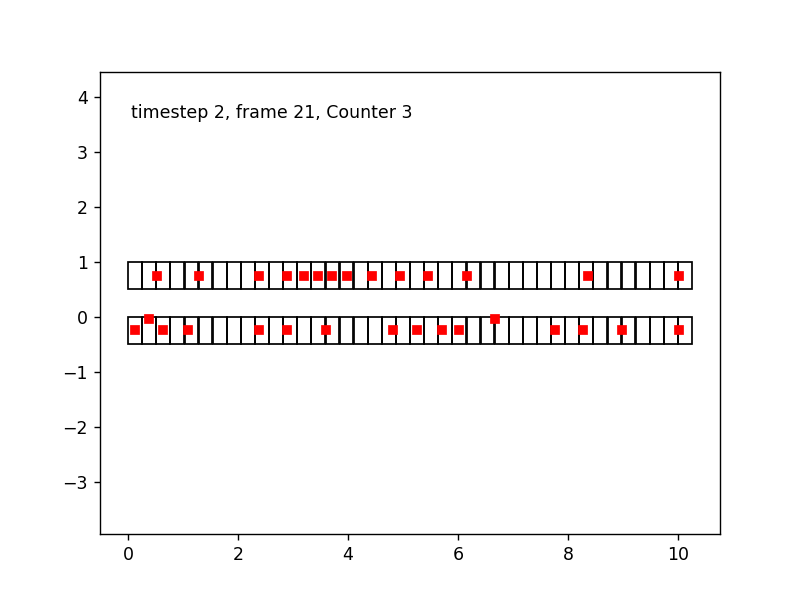

In [28]:

interact_manual(animationShow, 
        N=widgets.IntSlider(min=20,max=80,step=1,value=40),
        M=widgets.IntSlider(min=1,max=4,step=1,value=2),
        carnum=widgets.IntSlider(min=1,max=320,step=1,value=30),
        pChange = widgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.1),
        pSlow= widgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.1),
        maxVel=widgets.IntSlider(min=1,max=10,step=1,value=5),
        strategy=['random', 'symmetric', 'euro'],
        probs=['constant', 'uniform']  # If every car gets the same change probability or a random uniform distribution is used
        );